In [176]:
import scipy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#### *Load Network Topology*

In [177]:
# Load the .mat file
mat_data = scipy.io.loadmat(r'E:\University\Master\Project\Codes\6D-MAN\MAN157Nodes.mat')

# Display the keys in the loaded dictionary
print(mat_data.keys())

net_topology = mat_data['MAN157Nodes']
net_topology_ex = net_topology.copy()

print('the type of net_topology:', type(net_topology_ex))

topo_size = net_topology_ex.shape
print('the shape of net_topology: ', topo_size)

dict_keys(['__header__', '__version__', '__globals__', 'MAN157Nodes'])
the type of net_topology: <class 'numpy.ndarray'>
the shape of net_topology:  (157, 157)


In [178]:
# Make the adjacenccy matrix upper triangular
net_topology_ex = np.triu(net_topology_ex)

In [179]:
# flag to control plotting the network topology
plot_topology_flag = 0

# define two array to save source & destination 
source_storage = []
des_storage = []
weight_storage = []

#### *Extract all links in the topology*

In [180]:
# initialize the number of links in the topology
num_link = 0

for src_counter in range(topo_size[0]):
    for des_counter in range(topo_size[1]):
        if net_topology_ex[src_counter, des_counter] != 0:
            num_link += 1
            source_storage.append(src_counter)
            des_storage.append(des_counter)
            weight_storage.append(net_topology_ex[src_counter, des_counter])

source_storage = np.array(source_storage)
des_storage = np.array(des_storage)
weight_storage = np.array(weight_storage)

In [181]:
# create source-destination-weight matrix
matrix_src_des = np.column_stack((source_storage, des_storage, weight_storage))
print('the shape of source-des-weight matrix:', matrix_src_des.shape)


the shape of source-des-weight matrix: (220, 3)


In [182]:
# Create graph from adjacency matrix
G = nx.from_numpy_array(net_topology_ex)

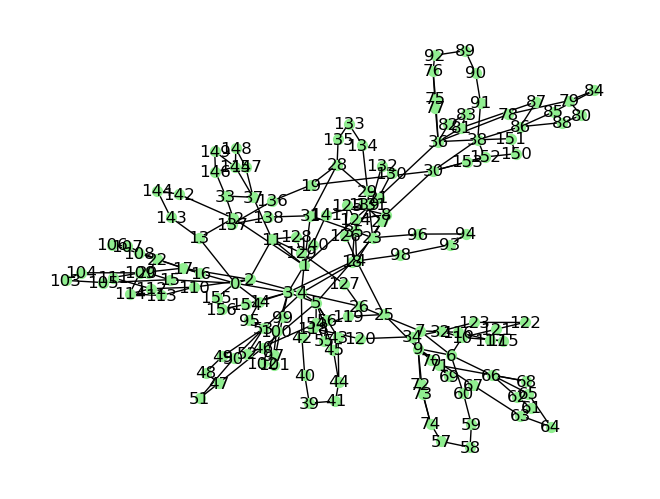

In [183]:
# Draw the graph
nx.draw(G, pos = nx.spring_layout(G), with_labels = True, node_color = 'lightgreen', node_size = 50)
plt.show()